### Initially run the first two cells

In [7]:
import ipywidgets as widgets
from IPython.display import Markdown, display
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss
#from scipy.stats import norm, t
import matplotlib.pyplot as plt
import json
import decimal
decimal.getcontext().prec = 4
import multiprocessing
from joblib import Parallel, delayed
import io
from scipy.special import btdtri

def printmd(string, color='red'):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))


def upload_file():
    printmd('**Upload the .csv data file with control/treatment in first column and binary observations in second column:**')
    uploader = widgets.FileUpload(accept = '.csv', multiple = False)
    display(uploader)
    return uploader   
    
    
def read_file(uploader):
    input_file = list(uploader.value.values())[0]
    content = input_file['content']
    content = io.StringIO(content.decode('utf-8'))
    df = pd.read_csv(content)
    return df

def do_classical_test(df, level_of_sig):
    str1 = df.columns[0]  ## column name of variations
    str2 = df.columns[1]  ## column name of observations
    
    variation1_name = df[str1].unique()[0] ## name of variation 1
    variation2_name = df[str1].unique()[1] ## name of variation 2
    
    dataset1 = df[df[str1] == variation1_name]
    dataset2 = df[df[str1] == variation2_name]
    
    ci_dataset1 = np.sqrt(dataset1[str2].mean()*(1 - dataset1[str2].mean())/len(dataset1[str2]))*ss.norm.ppf(1-level_of_sig/2)
    ci_dataset2 = np.sqrt(dataset1[str2].mean()*(1 - dataset1[str2].mean())/len(dataset2[str2]))*ss.norm.ppf(1-level_of_sig/2 )
    
    p1 = plt.bar(0, dataset1[str2].mean(), color = 'red', edgecolor = 'black', yerr = ci_dataset1, capsize = 15, label = variation1_name, width = 0.2)
    p2 = plt.bar(0.4, dataset2[str2].mean(), color = 'green', edgecolor = 'black', yerr = ci_dataset2, capsize = 15, label = variation2_name, width = 0.2)
    
    plt.legend(handles=[p1, p2], bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks([0, 0.4], [variation1_name, variation2_name])
    plt.show()
    
    t_stat, p_val = ss.ttest_ind(dataset1[str2], dataset2[str2])
    
    if t_stat<=0 and p_val <= level_of_sig:
        printmd(f'**The variation \'{variation2_name}\' has significantly higher conversion rate compared to the the \'{variation1_name}\'. The p value of the test is {p_val:.5f}.**', color = 'green')
        
    if t_stat>=0 and p_val <= level_of_sig:
        printmd(f'**The variation \'{variation1_name}\' has significantly higher conversion rate compared to the \'{variation2_name}\'. The p value of the test is {p_val:.5f}.**', color = 'red')
        
    if p_val > level_of_sig:
        printmd(f'**The test is inconclusive. P-value is {p_val: .5f}.**')
    #return t_stat, p_val
    

def calculate_expected_loss(control_simulation, treatment_simulation, treatment_won, min_difference_delta=0):
    control_simulation = np.array(control_simulation)
    treatment_simulation = np.array(treatment_simulation)
    
    loss_control = (treatment_simulation - min_difference_delta) - control_simulation
    loss_treatment = (control_simulation - min_difference_delta) - treatment_simulation
    
    all_loss_control = treatment_won * loss_control
    all_loss_treatment = (1 - treatment_won) * loss_treatment
    
    return np.mean(all_loss_control), np.mean(all_loss_treatment)


    
def do_bayesian_test(df, eps):
    str1 = df.columns[0]  ## column name of variations
    str2 = df.columns[1]  ## column name of observations
    
    variation1_name = df[str1].unique()[0] ## name of variation 1
    variation2_name = df[str1].unique()[1] ## name of variation 2
    
    if len(df[df[str1] == variation1_name]) < len(df[df[str1] == variation2_name]): ## variation1 is the one having larger sample size
        variation1_name = df[str1].unique()[1]
        variation2_name = df[str1].unique()[0]
        
    
    dataset1 = df[df[str1] == variation1_name]
    dataset2 = df[df[str1] == variation2_name]
    
    variation1_data = np.array(dataset1[str2])
    variation2_data = np.array(dataset2[str2])
    variation1_prop = len(variation1_data)/(len(variation1_data) + len(variation2_data))
    variation1_sample_size = len(variation1_data)
    variation2_sample_size = len(variation2_data)
    
    variation1_consumed_sample_size = np.ceil(variation1_sample_size/2 - 20).astype(int)
    variation2_consumed_sample_size = np.ceil(variation2_sample_size/2 - np.ceil(20 * (1 - variation1_prop)/variation1_prop).astype(int)).astype(int)
    variation1_consumed_sample_size_vec = []
    
    variation1_conversions = sum(variation1_data[0 : variation1_consumed_sample_size])
    variation2_conversions = sum(variation2_data[0 : variation2_consumed_sample_size])
    loss_variation1_vec = []
    loss_variation2_vec = []
    
    while variation1_consumed_sample_size <= variation1_sample_size and variation2_consumed_sample_size <= variation2_sample_size:
        variation1_consumed_sample_size += 20
        variation2_consumed_sample_size += np.ceil(20 * (1 - variation1_prop)/variation1_prop).astype(int)
        variation1_consumed_sample_size_vec.append(variation1_consumed_sample_size)
        variation1_conversions += sum(variation1_data[(variation1_consumed_sample_size - 20) : (variation1_consumed_sample_size)])
        variation2_conversions += sum(variation2_data[(variation2_consumed_sample_size - np.ceil(20 * (1 - variation1_prop)/variation1_prop).astype(int)) : (variation2_consumed_sample_size)])
            
        variation1_posterior_simulation = np.random.beta(1 + variation1_conversions, 1 + variation1_consumed_sample_size - variation1_conversions, size=5000)
        variation2_posterior_simulation = np.random.beta(1 + variation2_conversions, 1 + variation2_consumed_sample_size - variation2_conversions, size=5000)
        variation2_won = (variation2_posterior_simulation >= variation1_posterior_simulation).astype(int)
            
        expected_loss_variation1, expected_loss_variation2 = calculate_expected_loss(variation1_posterior_simulation, variation2_posterior_simulation, variation2_won)
        loss_variation1_vec.append(expected_loss_variation1)
        loss_variation2_vec.append(expected_loss_variation2)
        
    
    plt.plot(np.array([variation1_sample_size/2, variation1_consumed_sample_size]), np.array([eps, eps]), color = 'b', linewidth = 1)    
    plt.plot(variation1_consumed_sample_size_vec, loss_variation1_vec, color = 'r', label = f'{variation1_name} loss',  linewidth = 0.6)
    plt.plot(variation1_consumed_sample_size_vec, loss_variation2_vec, color = 'g', label = f'{variation2_name} loss', linewidth = 0.6)
    plt.legend(loc = 'upper right')
    plt.xlabel(f'{variation1_name} sample size')
    plt.ylabel('expected loss')
    #plt.title('Expected losses vs Sample size')
    #plt.text(11000, 0.001, 'eps = 0.0005')
    plt.show()
    #plt.savefig('plot11', dpi = 800)
    
    
def do_bayesian_test2(df, eps):
    str1 = df.columns[0]
    str2 = df.columns[1]
    
    variation1_name = df[str1].unique()[0]
    variation2_name = df[str1].unique()[1]
    
    if len(df[df[str1] == variation1_name]) < len(df[df[str1] == variation2_name]):
        variation1_name = df[str1].unique()[1]
        variation2_name = df[str1].unique()[0]
        
    dataset1 = df[df[str1] == variation1_name]
    dataset2 = df[df[str1] == variation2_name]
    
    variation1_data = np.array(dataset1[str2])
    variation2_data = np.array(dataset2[str2])
    variation1_prop = len(variation1_data)/(len(variation1_data) + len(variation2_data))
    
    variation1_sample_size = len(variation1_data)
    variation2_sample_size = len(variation2_data)
    number_of_steps = int(np.floor(len(variation1_data)/(2*20)))
    variation1_steps = np.linspace(len(variation1_data)/2, len(variation1_data), number_of_steps)
    variation2_steps = np.linspace(len(variation2_data)/2, len(variation2_data), number_of_steps)
    
    flag_variation1 = 0
    flag_variation2 = 0
    step = 0
    
    variation1_consumed_sample_size = round(variation1_steps[step])
    variation2_consumed_sample_size = round(variation2_steps[step])
    variation1_consumed_sample_size_vec = []
    variation1_conversions = sum(variation1_data[0:variation1_consumed_sample_size])
    variation2_conversions = sum(variation2_data[0:variation2_consumed_sample_size])
    loss_variation1_vec = []
    loss_variation2_vec = []
    
    while step < number_of_steps-1:
        step += 1
        new_step_variation1 = round(variation1_steps[step])
        new_step_variation2 = round(variation2_steps[step])
        
        variation1_conversions += sum(variation1_data[variation1_consumed_sample_size : new_step_variation1])
        variation2_conversions += sum(variation2_data[variation2_consumed_sample_size : new_step_variation2])
        
        variation1_consumed_sample_size = new_step_variation1
        variation2_consumed_sample_size = new_step_variation2
        variation1_consumed_sample_size_vec.append(variation1_consumed_sample_size)
        
        variation1_posterior_simulation = np.random.beta(1 + variation1_conversions, 1 + variation1_consumed_sample_size - variation1_conversions, size=5000)
        variation2_posterior_simulation = np.random.beta(1 + variation2_conversions, 1 + variation2_consumed_sample_size - variation2_conversions, size=5000)
        variation2_won = (variation2_posterior_simulation >= variation1_posterior_simulation).astype(int)
            
        expected_loss_variation1, expected_loss_variation2 = calculate_expected_loss(variation1_posterior_simulation, variation2_posterior_simulation, variation2_won)
        loss_variation1_vec.append(expected_loss_variation1)
        loss_variation2_vec.append(expected_loss_variation2)
        
        if expected_loss_variation1 <= eps:
            flag_variation1 = 1
            flag_variation2 = 0
        if expected_loss_variation2 <= eps:
            flag_variation2 = 1
            flag_variation1 = 0
    
    #_, (ax1, ax2) = plt.subplots(1, 2)
    plt.plot(np.array([variation1_steps[0], variation1_consumed_sample_size]), np.array([eps, eps]), color = 'b', linewidth = 1)    
    plt.plot(variation1_consumed_sample_size_vec, loss_variation1_vec, color = 'r', label = f'{variation1_name} loss',  linewidth = 0.6)
    plt.plot(variation1_consumed_sample_size_vec, loss_variation2_vec, color = 'g', label = f'{variation2_name} loss', linewidth = 0.6)
    plt.legend(loc = 'upper right')
    #ax1.xlabel(f'{variation1_name} sample size')
    #ax1.ylabel('expected loss')
    #plt.title('Expected losses vs Sample size')
    #plt.text(11000, 0.001, 'eps = 0.0005')
    plt.show()
    
    variation1_cr_mean = variation1_conversions/variation1_consumed_sample_size
    variation1_cr_lci = btdtri(variation1_conversions, variation1_consumed_sample_size - variation1_conversions, 0.025)
    variation1_cr_uci = btdtri(variation1_conversions, variation1_consumed_sample_size - variation1_conversions, 0.975)
    
    variation2_cr_mean = variation2_conversions/variation2_consumed_sample_size
    variation2_cr_lci = btdtri(variation2_conversions, variation2_consumed_sample_size - variation2_conversions, 0.025)
    variation2_cr_uci = btdtri(variation2_conversions, variation2_consumed_sample_size - variation2_conversions, 0.975)
    
    means = [variation1_cr_mean, variation2_cr_mean]
    err_low = [variation1_cr_mean - variation1_cr_lci, variation2_cr_mean - variation2_cr_lci]
    err_up = [variation1_cr_uci - variation1_cr_mean, variation2_cr_uci - variation2_cr_mean]
    p1 = plt.bar([0,0.4], means, color = ['red', 'green'], edgecolor = 'black', yerr = [err_low, err_up], capsize = 15, label = [variation1_name, variation2_name], width = 0.2)
    #p2 = plt.bar(0.4, variation2_cr_mean, color = 'green', edgecolor = 'black', yerr = [variation2_cr_mean - variation2_cr_lci, variation2_cr_uci - variation2_cr_mean], capsize = 15, label = variation2_name, width = 0.2)
    
    #plt.legend(handles=[p1], bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks([0, 0.4], [variation1_name, variation2_name])
    #plt.show()
    #plt.savefig('plot11', dpi = 800)
    
    if flag_variation1 == 1:
        printmd(f'**The variation {variation1_name} has significantly higher conversion rate compared to the variation {variation2_name}. Expected loss of {variation1_name} is below {eps}.**', color = 'red')
        
    if flag_variation2 == 1:
        printmd(f'**The variation {variation2_name} has significantly higher conversion rate compared to the variation {variation1_name}. Expected loss of {variation2_name} is below {eps}.**', color = 'green')
    
    if flag_variation1 == 0 and flag_variation2 == 0:
        printmd("**The test is inconclusive.**", color = 'black')

In [8]:
style = {'description_width': 'initial'}
def do_test(df, level_of_sig, epsilon, string):
    if string == 'Classical':
        do_classical_test(df, level_of_sig)
        
    if string == 'Bayesian':
        do_bayesian_test2(df, epsilon)
    
method_choice = widgets.Select(
                options = ['Classical', 'Bayesian'],
                value = 'Classical',
                description = f'<b>Method</b>',
                style = style
)

level_of_sig = widgets.BoundedFloatText(
                value = 0.05,
                min = 0.01,
                max = 0.1,
                #step = 0.01,
                description = f'<b>Level of Significance</b>',
                readout_format = '.4f',
                style = style
)

epsilon = widgets.BoundedFloatText(
        value = 0.001,
        min = 0.0000001,
        max = 0.1,
        #step = eps_min,
        description = f'<b>Expected Loss Threshold</b>',
        #readout = False,
        style = style
)
#eps_label = widgets.Label()
#eps_box = widgets.HBox([epsilon, eps_label])
#mylink = widgets.jslink((epsilon, 'value'), (eps_label, 'value'))

def threshold_display(arr):
    if arr == 'Classical':
        printmd('**Enter Level of Significance for Classical calculation:**')
        display(level_of_sig)
            
    if arr == 'Bayesian':
        printmd('**Enter expected loss threshold:**')
        display(epsilon)

### Upload the .csv data file. Should have variation name in first column and binary observations in second column.

In [9]:
up = upload_file()

<span style='color:red'>**Upload the .csv data file with control/treatment in first column and binary observations in second column:**</span>

FileUpload(value={}, accept='.csv', description='Upload')

### Choose your preferred method(Classical/Bayesian) from the list.

In [10]:
df = read_file(up)
printmd('**Choose preferred method for the test.**'); display(method_choice)

<span style='color:red'>**Choose preferred method for the test.**</span>

Select(description='<b>Method</b>', options=('Classical', 'Bayesian'), style=DescriptionStyle(description_widt…

In [11]:
threshold_display(method_choice.value)

<span style='color:red'>**Enter expected loss threshold:**</span>

BoundedFloatText(value=0.001, description='<b>Expected Loss Threshold</b>', max=0.1, min=1e-07, style=Descript…

### The following cell executes the test and show the result if it is conclusive.

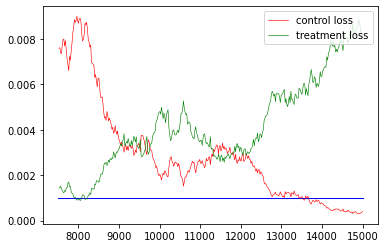

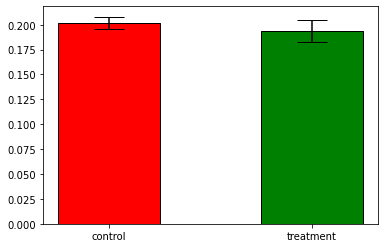

<span style='color:red'>**The variation control has significantly higher conversion rate compared to the variation treatment. Expected loss of control is below 0.001.**</span>

In [12]:
do_test(df, level_of_sig.value, epsilon.value, method_choice.value)

In [ ]:
## plot posterior distributions & mark quantiles